Лабораторна робота №7 Шкуропіснького Максима ФБ-33

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, MimeType, bbox_to_dimensions
from sentinelhub.aws import request
import shutil
from osgeo import gdal
import subprocess
import rasterio
import rasterio.plot
from shapely.geometry import Polygon
import geopandas as gpd
import shapely.wkt

/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen abc>:106: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.


1. Завантажити необхідні дані Sentinel-2 (або з Copernicus SciHub, або з
Google-диска). За допомогою бібліотеки sentinelhub написати скрипт для
завантаження супутникових знімків Sentinel-2, які покривають Київ (ROI — POLYGON((29.073321247506765 49.845775018245774,31.986007792928522
49.845775018245774,31.986007792928522 51.278667808079206,29.073321247506765
51.278667808079206,29.073321247506765 49.845775018245774)) )
Список ідентифікаторів Sentinel-2:
– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T11
5206
– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T11
5206

In [ ]:
lab_dir = os.path.join(os.getcwd(), "7")
os.makedirs(lab_dir, exist_ok=True)


config = SHConfig()
#config.aws_access_key_id = ''
#config.aws_secret_access_key = ''
config.save()

def download_sentinel_data(product_id: str):
    try:
        print(f"Завантаження продукту {product_id}...")
        request.download_safe_format(
            product_id,
            folder=lab_dir,
            redownload=False,
            data_collection='sentinel-s2-l2a'
        )
        print(f"Продукт {product_id} успішно завантажено.")
    except Exception as e:
        print(f"Помилка під час завантаження продукту {product_id}: {e}")



product_ids = [
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
]

for product_id in product_ids:
    download_sentinel_data(product_id)


Завантаження продукту S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206...


/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/request.py:245: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/data.py:353: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/data_safe.py:331: SHDeprecationWarning: AWS functionality will 

Продукт S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206 успішно завантажено.
Завантаження продукту S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206...


/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/request.py:245: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/data.py:353: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/josef/Desktop/lab/venv/lib/python3.12/site-packages/sentinelhub/aws/data_safe.py:331: SHDeprecationWarning: AWS functionality will 

Продукт S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206 успішно завантажено.


2. Засобами командного рядка операційної системи (демонстраційні
приклади розглянуті для ОС Windows), а також за допомогою бінаріїв
бібліотеки GDAL розробити автоматичний сценарій, який здійснюватиме
обробку даних ДЗЗ, відповідно до поставлених завдань. Для виконання
команд gdal у сценарії Python можна використовувати бібліотеки os та
command.
Над завантаженими даними Sentinel-2 відпрацювати наступні дії.
– Розпакування наборів архівів з продуктами ДЗЗ в новостворені папки,
назви яких відповідатимуть ідентифікаторам зображень.

In [33]:
def unpack_archives(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith(".SAFE.zip"):
            archive_path = os.path.join(folder_path, file)
            base_name = file[:-4]  # remove .zip
            target_dir = os.path.join(folder_path, base_name)

            if not os.path.exists(target_dir):
                print(f"Розпаковується: {file} -> {target_dir}")
                with zipfile.ZipFile(archive_path, 'r') as zip_ref:
                    zip_ref.extractall(target_dir)
                print(f"Успішно розпаковано в {target_dir}")

    for name in os.listdir(folder_path):
        if name.lower().endswith(".safe"):
            full_path = os.path.join(folder_path, name)
            new_name = os.path.join(folder_path, name.replace(".SAFE", ""))
            if not os.path.exists(new_name):
                shutil.move(full_path, new_name)
                print(f"Папку {full_path} перейменовано в {new_name}")
unpack_archives("/home/josef/Desktop/lab/7")

Папку /home/josef/Desktop/lab/7/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE перейменовано в /home/josef/Desktop/lab/7/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Папку /home/josef/Desktop/lab/7/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE перейменовано в /home/josef/Desktop/lab/7/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206


– Конкатенація каналів видимого, ближнього та середнього
інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в
єдиний GEOTIFF файл.

In [42]:
def concatenate_bands(input_dir, output_path, bands=[2, 3, 4, 8]):
    jp2_files = []
    for b in bands:
        band_str = f"{b:02}"
        for f in os.listdir(input_dir):
            if f.endswith(f"_B{band_str}_10m.jp2"):
                jp2_files.append(os.path.join(input_dir, f))
    jp2_files.sort()

    if not jp2_files:
        print(f"Не знайдено жодного .jp2 файлу в {input_dir} для бандів {bands}")
        return

    cmd = ["gdal_merge.py", "-separate", "-o", output_path] + jp2_files
    subprocess.run(cmd)
    print(f"Створено файл: {output_path}")


concatenate_bands(
    "/home/josef/Desktop/lab/7/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R10m",
    "/home/josef/Desktop/lab/7/merged_T36UUB.tif"
)
concatenate_bands(
    "/home/josef/Desktop/lab/7/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R10m",
    "/home/josef/Desktop/lab/7/merged_T36UUA.tif"
)

0...10...20...30...40...50...60...70...80...90...100 - done.
Створено файл: /home/josef/Desktop/lab/7/merged_T36UUB.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Створено файл: /home/josef/Desktop/lab/7/merged_T36UUA.tif


In [1]:
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
def show_rgb(path, bands=(3, 2, 1), title="Зображення"):
    with rasterio.open(path) as src:
        img = src.read(list(bands))
        img = np.transpose(img, (1, 2, 0))
        img = img / np.percentile(img, 98)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..12.84124830393487].


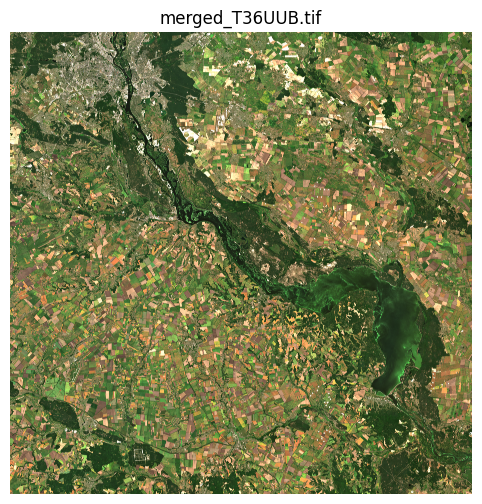

In [3]:
show_rgb("/home/josef/Desktop/lab/7/merged_T36UUB.tif", title="merged_T36UUB.tif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..12.221052631578948].


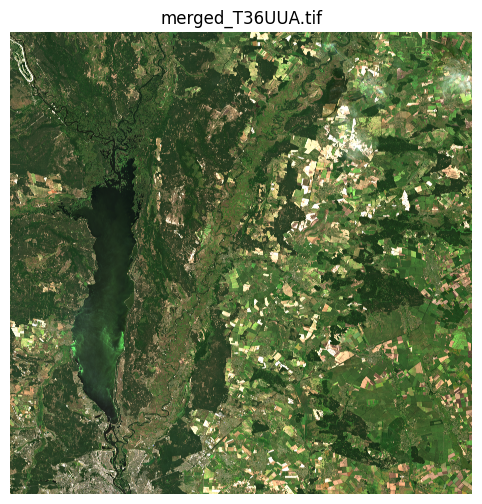

In [4]:
show_rgb("/home/josef/Desktop/lab/7/merged_T36UUA.tif", title="merged_T36UUA.tif")

Перепроектування супутникового зображення у проєкцію 4326.

In [5]:
def reproject_image(input_path, output_path, epsg="EPSG:4326"):
    cmd = [
        "gdalwarp",
        "-t_srs", epsg,
        input_path,
        output_path
    ]
    subprocess.run(cmd)
    print(f"Перепроєктовано у {epsg}: {output_path}")

reproject_image("/home/josef/Desktop/lab/7/merged_T36UUB.tif", "/home/josef/Desktop/lab/7/reproj_T36UUB.tif")
reproject_image("/home/josef/Desktop/lab/7/merged_T36UUA.tif", "/home/josef/Desktop/lab/7/reproj_T36UUA.tif")

Creating output file that is 13257P x 8536L.
Processing /home/josef/Desktop/lab/7/merged_T36UUB.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Перепроєктовано у EPSG:4326: /home/josef/Desktop/lab/7/reproj_T36UUB.tif
Creating output file that is 13331P x 8421L.
Processing /home/josef/Desktop/lab/7/merged_T36UUA.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Перепроєктовано у EPSG:4326: /home/josef/Desktop/lab/7/reproj_T36UUA.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..12.982167352537722].


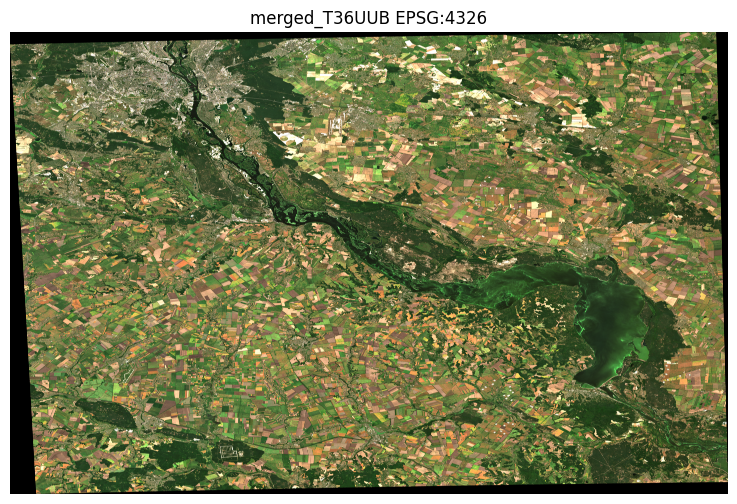

In [4]:
show_rgb("/home/josef/Desktop/lab/7/reproj_T36UUB.tif", title="merged_T36UUB EPSG:4326")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..12.433734939759036].


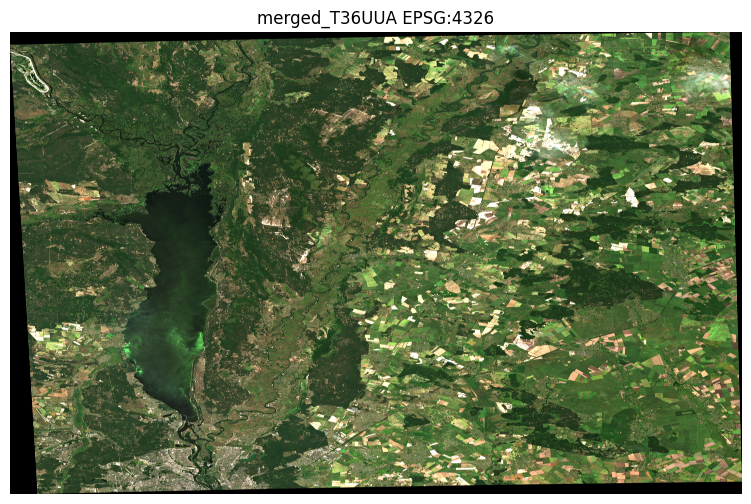

In [5]:
show_rgb("/home/josef/Desktop/lab/7/reproj_T36UUA.tif", title="merged_T36UUA EPSG:4326")

Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

In [3]:
def concatenate_all_to_one(file_list, output_path):
    if not file_list:
        raise ValueError("Список файлів для об'єднання порожній")

    input_str = " ".join(file_list)
    command = f"gdal_merge.py -o {output_path} {input_str}"

    print("Команда об'єднання:", command)
    exit_code = os.system(command)

    if exit_code == 0:
        print(f"Файли об'єднано в: {output_path}")
    else:
        print("Помилка під час виконання gdal_merge")
files_to_merge = [
    "/home/josef/Desktop/lab/7/reproj_T36UUA.tif",
    "/home/josef/Desktop/lab/7/reproj_T36UUB.tif"
]
concatenate_all_to_one(files_to_merge, "/home/josef/Desktop/lab/7/combined.tif")


Команда об'єднання: gdal_merge.py -o /home/josef/Desktop/lab/7/combined.tif /home/josef/Desktop/lab/7/reproj_T36UUA.tif /home/josef/Desktop/lab/7/reproj_T36UUB.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Файли об'єднано в: /home/josef/Desktop/lab/7/combined.tif


In [2]:
show_rgb("C:/Users/maxym/Documents/KPI/2 курс/АПД/lab7/combined.tif", title="combined.tif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..13.03581267217631].


Обрізання результуючого зображення по заданому векторному контуру.

In [4]:
def generate_polygon_shapefile(output_folder):
    wkt_poly = (
        "POLYGON((29.073321247506765 49.845775018245774, "
        "31.986007792928522 49.845775018245774, "
        "31.986007792928522 51.278667808079206, "
        "29.073321247506765 51.278667808079206, "
        "29.073321247506765 49.845775018245774))"
    )

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    shapefile_path = os.path.join(output_folder, "Kyiv.shp")
    polygon = shapely.wkt.loads(wkt_poly)
    gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326")
    gdf.to_file(shapefile_path)

    print(f"Створено SHP-файл: {shapefile_path}")
    return shapefile_path

def crop_raster(input_raster, shapefile_path, epsg_out="EPSG:32636"):
    if not os.path.exists(input_raster):
        print(f"Файл не знайдено: {input_raster}")
        return
    if not os.path.exists(shapefile_path):
        print(f"Shapefile не знайдено: {shapefile_path}")
        return

    out_name = os.path.splitext(os.path.basename(input_raster))[0] + "_clipped.tif"
    out_raster = os.path.join(os.path.dirname(input_raster), out_name)

    cmd = [
        "gdalwarp",
        "-cutline", shapefile_path,
        "-crop_to_cutline",
        "-overwrite",
        "-t_srs", epsg_out,
        input_raster,
        out_raster
    ]

    try:
        subprocess.run(cmd, check=True)
        print(f"Обрізано: {out_raster}")
    except subprocess.CalledProcessError as e:
        print(f"Помилка обрізання: {e}")

shp_path = generate_polygon_shapefile("/home/josef/Desktop/lab/7")
crop_raster("/home/josef/Desktop/lab/7/combined.tif", shp_path)


Створено SHP-файл: /home/josef/Desktop/lab/7/Kyiv.shp
Creating output file that is 19423P x 15256L.
Processing /home/josef/Desktop/lab/7/combined.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Обрізано: /home/josef/Desktop/lab/7/combined_clipped.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..15.1296].


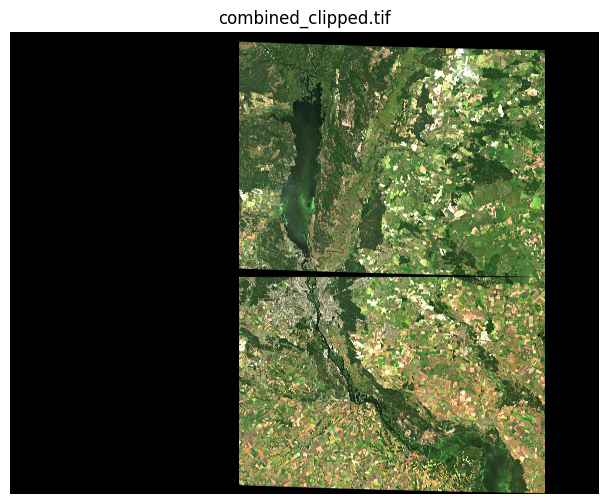

In [3]:
show_rgb("C:/Users/maxym/Documents/KPI/2 курс/АПД/lab7/combined_clipped.tif", title="combined_clipped.tif")